In [3]:
import os
import nibabel as nib
import pandas as pd
import pyradiomics
# from pyradiomics import featureextractor
import logging

# Optional: suppress verbose logging
logging.getLogger('radiomics').setLevel(logging.ERROR)

# Path to your segmented tumor masks
base_dir = r"C:\PKG - UPENN-GBM-NIfTI\UPENN-GBM\NIfTI-files\automated_segm"
output_csv = "tumor_features.csv"

# Configure feature extractor
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.enableAllFeatures()

data = []

for file in os.listdir(base_dir):
    if file.endswith('.nii.gz'):
        patient_id = file.split('_')[2] if '_' in file else file.split('.')[0]
        path = os.path.join(base_dir, file)

        # Since it's a binary tumor mask, use the same file as both image and mask
        try:
            result = extractor.execute(imageFilepath=path, maskFilepath=path)
            filtered_result = {k: v for k, v in result.items() if "diagnostics" not in k}
            filtered_result['PatientID'] = patient_id
            data.append(filtered_result)
        except Exception as e:
            print(f"Failed for {file}: {e}")

# Create DataFrame and save to CSV
df = pd.DataFrame(data)
df.set_index("PatientID", inplace=True)
df.to_csv(output_csv)

print(f"Saved {len(df)} feature vectors to {output_csv}")

ModuleNotFoundError: No module named 'pyradiomics'

In [8]:
import os
import torch
import torch.nn as nn
import nibabel as nib
import numpy as np
import pandas as pd
from scipy.ndimage import zoom

# ======= 1. CNN Model (Simple 3D CNN as feature extractor) ============
class TumorFeatureCNN(nn.Module):
    def __init__(self):
        super(TumorFeatureCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((4, 4, 4))  # Output shape: (16, 4, 4, 4)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        return x.view(x.size(0), -1)  # Flatten features (batch_size, 1024)

# ========= 2. NIfTI loader and preprocessing ===============
def load_nifti(path, target_shape=(64, 64, 64)):
    data = nib.load(path).get_fdata()
    data = (data - data.min()) / (data.max() - data.min() + 1e-6)  # Normalize to [0, 1]
    zoom_factors = [t / s for t, s in zip(target_shape, data.shape)]
    data = zoom(data, zoom_factors, order=1)  # Resize
    data = np.expand_dims(data, axis=0)  # Add channel dim (1, D, H, W)
    return torch.tensor(data, dtype=torch.float32)

# ========== 3. Feature Extraction Pipeline ================
def extract_features_from_folder(folder_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TumorFeatureCNN().to(device).eval()

    features = []
    patient_ids = []

    for fname in os.listdir(folder_path):
        if fname.endswith('.nii.gz'):
            path = os.path.join(folder_path, fname)
            # Extract everything before "_automated_approx_segm.nii.gz"
            patient_id = fname.replace('_automated_approx_segm.nii.gz', '')

            try:
                tensor = load_nifti(path).unsqueeze(0).to(device)
                with torch.no_grad():
                    feat = model(tensor).cpu().numpy().flatten()
                features.append(feat)
                patient_ids.append(patient_id)
            except Exception as e:
                print(f"[ERROR] {fname}: {e}")


    df = pd.DataFrame(features)
    df.insert(0, "PatientID", patient_ids)
    return df

# ========== 4. Run and Save to CSV ========================
if __name__ == "__main__":
    input_folder = r"C:\PKG - UPENN-GBM-NIfTI\UPENN-GBM\NIfTI-files\automated_segm"
    output_csv = "cnn_tumor_features.csv"

    df = extract_features_from_folder(input_folder)
    df.to_csv(output_csv, index=False)
    print(f"✅ Features extracted and saved to {output_csv}")

✅ Features extracted and saved to cnn_tumor_features.csv


In [13]:
import pandas as pd

# File paths
cnn_features_path = r'D:\mlpr data\Glioblastoma-ML-model\cnn_tumor_features.csv'
clinical_info_path = r'D:\mlpr data\Glioblastoma-ML-model\UPENN-GBM_clinical_info_v2.1.csv'
output_path = r'D:\mlpr data\Glioblastoma-ML-model\cnn_stacked.csv'

# Load CSVs
cnn_df = pd.read_csv(cnn_features_path)
clinical_df = pd.read_csv(clinical_info_path)

# Merge: match cnn_df.PatientID with clinical_df.ID
merged_df = cnn_df.merge(
    clinical_df[['ID', 'Survival_from_surgery_days_UPDATED']],
    left_on='PatientID',
    right_on='ID',
    how='left'
)

# Drop redundant 'ID' column (optional)
merged_df.drop(columns=['ID'], inplace=True)

# Save result
merged_df.to_csv(output_path, index=False)

print("✅ Merged CSV saved as cnn_stacked.csv at:", output_path)


✅ Merged CSV saved as cnn_stacked.csv at: D:\mlpr data\Glioblastoma-ML-model\cnn_stacked.csv


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.ensemble import StackingClassifier

# Load the dataset
file_path = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\cnn_stacked.csv"
df = pd.read_csv(file_path)

# Convert target column to numeric
df["Survival_from_surgery_days_UPDATED"] = pd.to_numeric(df["Survival_from_surgery_days_UPDATED"], errors="coerce")

# Drop rows where target variable is NaN
df = df.dropna(subset=["Survival_from_surgery_days_UPDATED"])

# Percentile-Based Binning for classification
percentiles = np.percentile(df["Survival_from_surgery_days_UPDATED"], [25, 50, 75])
bins = [0, percentiles[0], percentiles[1], percentiles[2], np.inf]
labels = [0, 1, 2, 3]
df["Survival_Category"] = pd.cut(df["Survival_from_surgery_days_UPDATED"], bins=bins, labels=labels)

# Separate features and target
X = df.drop(columns=[df.columns[0], "Survival_from_surgery_days_UPDATED", "Survival_Category"])  # Drop ID and targets
y = df["Survival_Category"]

# Fill missing values with median
X = X.apply(pd.to_numeric, errors="coerce").fillna(X.median())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality reduction
lda = LinearDiscriminantAnalysis(n_components=3)
X_lda = lda.fit_transform(X_scaled, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42, stratify=y)

# Balance classes with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Define base models
rf_clf = RandomForestClassifier(n_estimators=150, random_state=42)
xgb_clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
log_reg = LogisticRegression(max_iter=1000)
lda_clf = LinearDiscriminantAnalysis()

# Voting Classifier
ensemble_model = VotingClassifier(
    estimators=[("RandomForest", rf_clf), ("XGBoost", xgb_clf), ("LogReg", log_reg), ("LDA", lda_clf)],
    voting="hard"
)

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[("RandomForest", rf_clf), ("XGBoost", xgb_clf), ("LogReg", log_reg), ("LDA", lda_clf)],
    final_estimator=RandomForestClassifier()
)

# Train models
stacking_clf.fit(X_train, y_train)
ensemble_model.fit(X_train, y_train)

# Predictions
y_pred_ensemble = ensemble_model.predict(X_test)
y_pred_stacking = stacking_clf.predict(X_test)

# Evaluate
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
report_ensemble = classification_report(y_test, y_pred_ensemble)
report_stacking = classification_report(y_test, y_pred_stacking)

print(f"Ensemble Model Accuracy with LDA: {accuracy_ensemble:.2f}")
print("Classification Report:\n", report_ensemble)
print(f"Stacking Model Accuracy with LDA: {accuracy_stacking:.2f}")
print("Classification Report:\n", report_stacking)

Ensemble Model Accuracy with LDA: 0.99
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      0.97      0.98        29
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        29

    accuracy                           0.99       117
   macro avg       0.99      0.99      0.99       117
weighted avg       0.99      0.99      0.99       117

Stacking Model Accuracy with LDA: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      0.86      0.93        29
           2       0.94      1.00      0.97        29
           3       0.97      1.00      0.98        29

    accuracy                           0.97       117
   macro avg       0.97      0.97      0.96       117
weighted avg       0.97      0.97      0.96       117



In [ ]:
from sklearn.metrics import balanced_accuracy_score

# Balanced Accuracy
balanced_acc_ensemble = balanced_accuracy_score(y_test, y_pred_ensemble)
balanced_acc_stacking = balanced_accuracy_score(y_test, y_pred_stacking)

print(f"Balanced Accuracy (Ensemble): {balanced_acc_ensemble:.2f}")
print(f"Balanced Accuracy (Stacking): {balanced_acc_stacking:.2f}")

Balanced Accuracy (Ensemble): 0.99
Balanced Accuracy (Stacking): 0.97


In [ ]:
from lifelines.utils import concordance_index

# Get original survival times for y_test samples
# Make sure the test set index aligns with the original dataframe
true_survival_times = y_test.copy()
true_survival_times = df.loc[y_test.index, "Survival_from_surgery_days_UPDATED"]

# Define bin midpoints (same binning as earlier)
bin_midpoints = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]

# Map predicted categories to survival time estimates
pred_survival_ensemble = [bin_midpoints[int(label)] for label in y_pred_ensemble]
pred_survival_stacking = [bin_midpoints[int(label)] for label in y_pred_stacking]

# Compute Concordance Index
c_index_ensemble = concordance_index(true_survival_times, pred_survival_ensemble)
c_index_stacking = concordance_index(true_survival_times, pred_survival_stacking)

print(f"Concordance Index (Ensemble): {c_index_ensemble:.2f}")
print(f"Concordance Index (Stacking): {c_index_stacking:.2f}")

Concordance Index (Ensemble): 0.88
Concordance Index (Stacking): 0.88


d:\mlpr data\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|===================| 2334/2340 [01:51<00:00]        

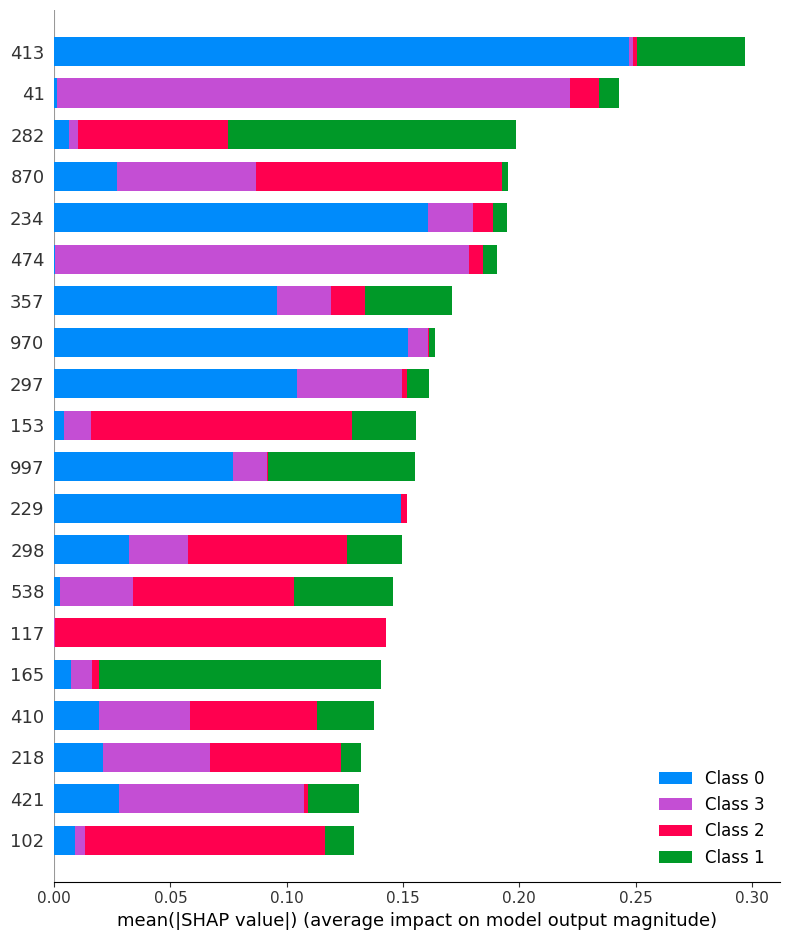

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (1024, 4)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [5]:
import shap

# Use original scaled data, not LDA-transformed (SHAP needs original features)
# So we'll fit one model (e.g., XGBoost) on X_scaled instead of X_lda
xgb_clf.fit(X_scaled, y)  # Refit on full data or use X_train if preferred

# Create SHAP explainer
explainer = shap.Explainer(xgb_clf, X_scaled)
shap_values = explainer(X_scaled)

# Plot global feature importance
shap.summary_plot(shap_values, X, plot_type="bar")

# Plot a single prediction explanation
shap.plots.waterfall(shap_values[0])  # for first sample


In [ ]:
from sklearn.feature_selection import VarianceThreshold
import pandas as pd

# Load data
file_path = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv"
df = pd.read_csv(file_path)

# Drop ID and target for variance calculation
df_numeric = df.drop(columns=["PatientID", "Survival_from_surgery_days_UPDATED"], errors='ignore')

# Encode categorical if any
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')
df_numeric = df_numeric.fillna(df_numeric.median())

# Apply Variance Threshold
selector = VarianceThreshold(threshold=0.10)
selector.fit(df_numeric)

# Get selected feature names
selected_columns = df_numeric.columns[selector.get_support()]

# Include essential columns back (ID, target)
columns_to_keep = list(selected_columns) + ["PatientID", "Survival_from_surgery_days_UPDATED"]
columns_to_keep = [col for col in columns_to_keep if col in df.columns]  # filter in case of missing

# Save filtered dataset
filtered_df = df[columns_to_keep]
filtered_df.to_csv("merged_lessVar.csv", index=False)

# Print summary
print(f"Original number of features: {df_numeric.shape[1]}")
print(f"Number of features with significant variability: {len(selected_columns)}")
print(f"Removed {df_numeric.shape[1] - len(selected_columns)} low-variance columns.")


C:\Users\asp61\AppData\Local\Temp\ipykernel_45528\1284258140.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
d:\mlpr data\.venv\lib\site-packages\sklearn\feature_selection\_variance_threshold.py:114: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


Original number of features: 9514
Number of features with significant variability: 5938
Removed 3576 low-variance columns.

Top 20 high-variance features:
DSC_PSR_ED_Intensity_Energy_x    1.858320e+18
FLAIR_ED_Intensity_Energy_x      9.756742e+17
DSC_PSR_ED_Intensity_Energy_y    9.149651e+17
T1_ED_Intensity_Energy_x         6.299616e+17
T2_ED_Intensity_Energy_x         4.846451e+17
FLAIR_ED_Intensity_Energy_y      3.540650e+17
DSC_PSR_NC_Intensity_Energy_x    2.685900e+17
DTI_AD_ED_Intensity_Energy_x     2.128812e+17
T1_ED_Intensity_Energy_y         2.125958e+17
DTI_TR_ED_Intensity_Energy_x     1.758371e+17
T2_NC_Intensity_Energy_x         1.744170e+17
T2_ED_Intensity_Energy_y         1.580942e+17
DTI_RD_ED_Intensity_Energy_x     1.465440e+17
DSC_PSR_NC_Intensity_Energy_y    1.338796e+17
DSC_PSR_ET_Intensity_Energy_x    1.196634e+17
DTI_AD_ED_Intensity_Energy_y     1.016272e+17
FLAIR_NC_Intensity_Energy_x      9.544239e+16
FLAIR_ET_Intensity_Energy_x      9.542435e+16
DTI_TR_ED_Intensi